# Capability Correlations

Let's start by importing all of the necessary libraries to conduct the analysis. 

In [3]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
from IPython.display import display, HTML

# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### Table of Contents:
- [1. Database Matrix of Occurences](#one)
  - [1.1. Getting the data from Neo4j](#one-one)
  - [1.2. Designing the queries](#one-two)    
  - [1.3. The first part of the matrix: No intersections.](#one-three)
  - [1.4. The second part of the matrix: Intersections.](#one-four)
  - [1.5. Testing the co-occurence matrix](#one-five)
  - [1.6. Printing the matrix](#one-six)
- [2. Co-occurence by country](#two)
  - [2.1. Co-ocurence matrixes for countries](#two-one)
  - [2.2. Transforming the co-occurence matrix into a list](#two-two)
  - [2.3. Visualizing correlations](#two-three)
  - [2.4. Creating a correlation matrix](#two-four)
    - [2.4.1. Regular Matrix](#two-four-one)
    - [2.4.2. Reordered Matrix: Clustermap](#two-four-two)
  - [2.5. Country profiles](#two-five)
- [3. Contextual Relations](#three)
    - [3.1. GDP per capita](#three-one)
        - [3.1.1. GDP per capita and capabilities](#three-one-one)
        - [3.1.2. Country Profiles and Correlation: Denmark](#three-one-two)
        - [3.1.3. Country Profiles and Correlation: Other countries](#three-one-three)
    - [3.2. Collaborations](#three-two)
        - [3.2.1. Collaboration Matrix](#three-two-one)
        - [3.2.2. Collaborations and Capabilities](#three-two-two)
        - [3.2.3. Normalized Collaborations and Capabilities](#three-two-three)
- [4. The case of Denmark](#four)
    - [4.1. Visualizing Differences](#four-one)
    - [4.2. Understanding Differences](#four-two)

## 1. Database Matrix of Occurences <a class="anchor" id="one"></a>

In order to establish a base for understading the basis of the work, we wish to understand the occurence of severall feedstocks, processing technologies and outputs in our database. 

For example, how many assets (patents, papers, etc) contain the mix of processing technology X for output Y? 

To understand this in a more general way, the [AMICA](https://amica-pathfinder.net/) database will be transformed in an [co-occurence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix). This means, in the above described example that the number of assets that contain that mix will be an entry in a matrix, whyle the corresponfing technology and output will be columns/lines of the matrix. 

### 1.1. Getting the data from Neo4j <a class="anchor" id="one-one"></a>

The first step in the analysis is to get the data from the [AMICA](https://amica-pathfinder.net/) database. This data is stored in a graph database of the type [Neo4j](https://neo4j.com/). 

We use [py2neo](http://py2neo.org/v3/) to establish a connection to the neo4j database. 

In [4]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

### 1.2. Designing the queries <a class="anchor" id="one-two"></a>

Two queries to the database were designed, the first, only related to non intersecting data, this means, looking for co-occurences of:
- outputs and technologies that appear together in an asset. 
- technologies and feedstocks that appear together in an asset.   
- feedstocks and outputs that appear together in an asset. 

In [5]:
query_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                RETURN fs.term, pt.term, out.term, count(a)
                        """

The second query is designed to also fetch the intersections between different outputs, different processing technologies and different feedstocks. This relates to: 
- outputs that appear together in the same asset. 
- technologies that appear together in the same asset.
- outputs that appear together in the same asset. 

In [6]:
# issue: this query needs to be divided by two when building the matrix -> NON OPTIMIZED
process_variables = ['Feedstock', 'Output', 'ProcessingTech']
query_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                WHERE fs<>t
                                RETURN fs.term, t.term, count(a)
                      """

### 1.3. The first part of the matrix: No intersections. <a class="anchor" id="one-three"></a>

In order to get the axis of our co-occurence matrix we make all the necessary queries and gather all the names that appear in a `matrix_axis_names` list.

In [7]:
# Return query as pandas dataframe 
data_no_intersections = DataFrame(connection_to_graph.data(query_no_interestions)).as_matrix()

# Get axis names from columns and append to list
feedstock_names = set(list(data_no_intersections[:, 1]))
processing_technology_names = set(list(data_no_intersections[:, 2]))
output_names = set(list(data_no_intersections[:, 3]))
matrix_axis_names = list(feedstock_names) + list(processing_technology_names) + list(output_names)

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in matrix_axis_names:
                matrix_axis_names.append(name)

The co-occurence matrix will be called `matrix`. In order to get things started we need two things: 

- An empty matrix with the shape of the previously built axis:

In [8]:
matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])

- A function that given a certain name, returns the position of that name in a list:

In [9]:
def find_index(something, in_list):
    return in_list.index(something)

Finally, we can start building the first part of the matrix. To do so, we iterated over all of the rows of the data retreived in the `data_no_intersections` table. 

In [10]:
# for every row in original response
for row in data_no_intersections:
    # the last column is the frequency 
    frequency = row[0]
    indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
    # add frequency value to matrix position
    for pair in itertools.combinations(indexes, 2):
        matrix[pair[0], pair[1]] += frequency
        matrix[pair[1], pair[0]] += frequency

### 1.4. The second part of the matrix: Intersections. <a class="anchor" id="one-four"></a>

The second part of the matrix that should be built related to the second query. Intersecting categories. 

In [11]:
# for every type of asset
for category in process_variables:
    print 'Processing ', category
    # execute the query 
    process_data = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    # fill the matrix
    for row in process_data:
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        #     add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
            matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized

Processing  Feedstock
Processing  Output
Processing  ProcessingTech


### 1.5. Testing the co-occurence matrix <a class="anchor" id="one-five"></a>

Some basic statistics about the co-occurence matrix. 

In [12]:
print 'Rows:', matrix.shape[0]
print 'Columns:', matrix.shape[1]
print 'Mean: ', np.mean(matrix)
print 'Standart Deviation', np.std(matrix)
print 'Max: ', np.amax(matrix)
print 'Min: ', np.amin(matrix)

Rows: 342
Columns: 342
Mean:  1.3187989466844499
Standart Deviation 15.649910770705663
Max:  1626.0
Min:  0.0


After testing, we normalize the matrix.

In [13]:
normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)

Symmetricality verification of normalized and non-normlized co-occurence matrixes. 

In [14]:
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

print 'The non normalized matrix is symmetrical: {}'.format(check_symmetric(matrix, 1e-8))
print 'The normalized matrix is symmetrical: {}'.format(check_symmetric(normalized_matrix, 1e-8))

The non normalized matrix is symmetrical: True
The normalized matrix is symmetrical: True


The following cell will verify if there is a non-zero element in the diagonal of the matrix. 

In [15]:
for column_number in range(matrix.shape[0]):
    if matrix[column_number, column_number] != 0:
        print 'Non-zero entry found in entry {}'.format(column_number)

### 1.6. Printing the matrix <a class="anchor" id="one-six"></a>

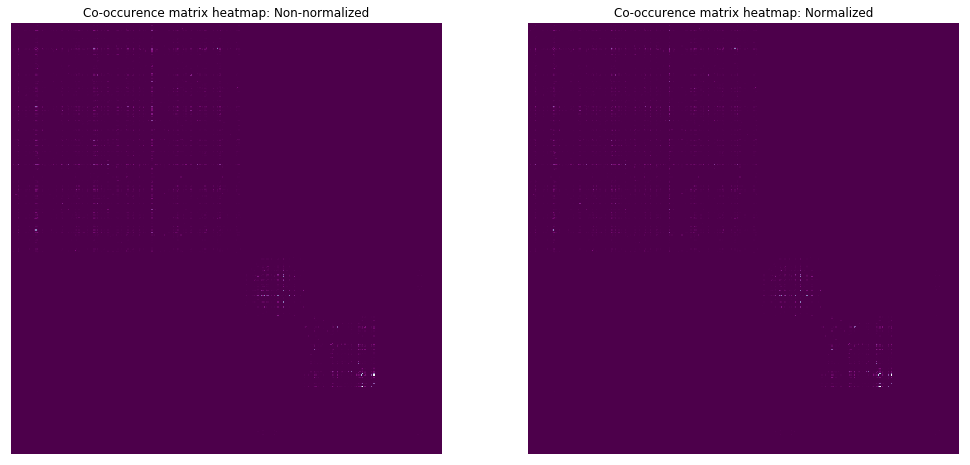

In [16]:
# create subplots
plt.subplots(2,1,figsize=(17,17))

plt.subplot(121)
sns.heatmap(matrix, cmap='BuPu_r',  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Non-normalized')

plt.subplot(122)
sns.heatmap(normalized_matrix, cmap='BuPu_r', cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Normalized')
plt.show()

## 2. Co-occurences and countries <a class="anchor" id="two"></a>

In this part of the analysis, severall co-occurence matrixes will be produced. Ideally, one for every country in the database. 

### 2.1. Co-ocurence matrixes for countries <a class="anchor" id="two-one"></a>

We start by getting a list of all of the countries in the neo4j database. 

In [17]:
country_query = """ MATCH (n:Country) 
                    WITH n.name AS Country 
                    RETURN Country;
                    """

country_names = list(set(DataFrame(connection_to_graph.data(country_query)).as_matrix()[:, 0]))
country_names.sort()

print 'The country list has {} countries.'.format(len(country_names))

The country list has 145 countries.


After doing this, we prepare a function that given a certain country, will retrieve the co-occurence matrix. This process is similar to the process in "[1.3. The first part of the matrix: No intersections](#one-three)" but applied to a particular country. By aggregating the process done before in a single function. 

In [18]:
def get_country_matrix(country, normalization=True):
    
    # define queries
    country_no_interestions = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.country = "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(country)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    country_intersections = """     MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.country = "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(country_no_interestions)).as_matrix()
    
    # create matrix
    country_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            country_matrix[pair[0], pair[1]] += frequency
            country_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(country_intersections.format(category, category, country))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                country_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                country_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    normalized_country_matrix = (country_matrix - np.mean(country_matrix)) / np.std(country_matrix)
    
    # dynamic return 
    if normalization == True:
        return normalized_country_matrix
    else: 
        return country_matrix

Let's create a function that returns basic stats given a matrix. With this function, we can gain insight into the previous function. 

In [19]:
def basic_stats(a_matrix):
    print 'Rows:', a_matrix.shape[0]
    print 'Columns:', a_matrix.shape[1]
    print 'Mean: ', np.mean(a_matrix)
    print 'Standart Deviation', np.std(a_matrix)
    print 'Max: ', np.amax(a_matrix)
    print 'Min: ', np.amin(a_matrix)
    print 'Symmetry: ', check_symmetric(matrix, 1e-8)
    print ''

Let's test a couple of countries. By getting their co-occurence matrix and printing its properties. 

In [20]:
print 'Denmark co-occurence matrix stats:'
basic_stats(get_country_matrix('Denmark', normalization=True))
print 'Sweden co-occurence matrix stats:'
basic_stats(get_country_matrix('Sweden', normalization=True))

Denmark co-occurence matrix stats:
Rows: 342
Columns: 342
Mean:  2.2477070913378225e-17
Standart Deviation 1.0
Max:  98.71619845088439
Min:  -0.043307401534452276
Symmetry:  True

Sweden co-occurence matrix stats:
Rows: 342
Columns: 342
Mean:  7.046865475545606e-18
Standart Deviation 1.0
Max:  111.13602822340711
Min:  -0.06205868957115324
Symmetry:  True



### 2.2. Transforming the co-occurence matrix into a list <a class="anchor" id="two-two"></a>

One of the goals of the analysis is to understand how each country relates to another. To do this, we will need to transform the matrix of a given country into an array. 

After doing this we will be able to compare the array of each one of the countries, by computing their difference or correlation for example. 

Let's start by creating a function that given a symetric matrix, as the ones shown above, returns a list. This list will have an entry by position in the matrix. But since the matrixes are symmetrical, the list will only receive half of the matrix. 

This means that for a matrix of dimensions 342x342 the list will have a total of 58 482 entries. 

In [21]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

### 2.3. Visualizing correlations <a class="anchor" id="two-three"></a>

Let's visualize the lists produced by this workflow for two different countries. 

We first select two countries.

In [22]:
spectrum_countries = ['''People's Republic of China''', 'United States of America']

We then create a matrix where each row is the vector that describes the country's capabilities.

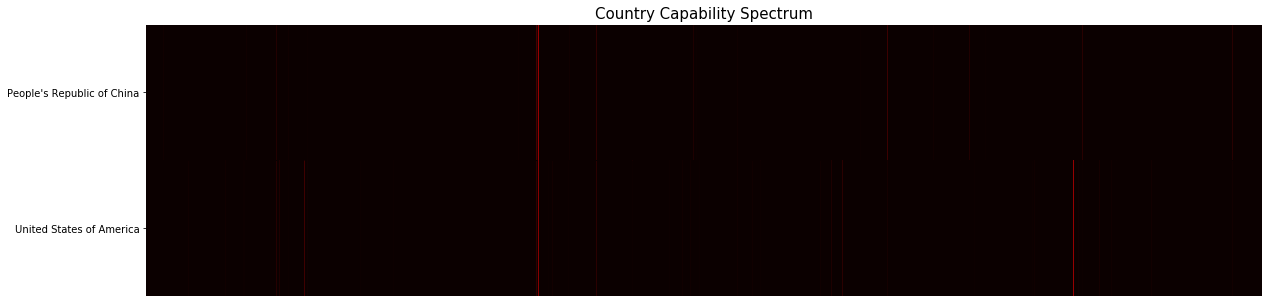

In [251]:
# apply functions to both countries
country_1_list = get_list_from(get_country_matrix(spectrum_countries[0], normalization=True))
country_2_list = get_list_from(get_country_matrix(spectrum_countries[1], normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((country_1_list, country_2_list))

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='hot', cbar=None, square=False, yticklabels=[spectrum_countries[0], spectrum_countries[1]], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Country Capability Spectrum', size=15)
plt.show()

We can see that the spectrum differs significantly in some areas. Please note that all of the measure were normalized prior to the plotting.

### 2.4. Creating a correlation matrix <a class="anchor" id="two-four"></a>

#### 2.4.1. Regular Matrix <a class="anchor" id="two-four-one"></a>

In this part of the analysis we will start correlating countries in relation to their capabilities. 

The correlation matrix follows the following principle: 
- Entry (i, j) is the correlation index between country i and country j
- The correlation index between country i and j is the absolute average difference between the capability list of country i and j.

Now, taking the list of countries previously established, we can iterate through it and fill the matrix. 

To improve eficiency, we first create a dictionnary where each key is a country, and each value, the capability list.

In the case that the databse contains no assets about a certain country, that country will be discarted. 

In [24]:
# create dictionnary
country_capability_dict = {}
counter = 0

# iterate through countries
for country in country_names:
    counter += 1
    country_matrix = get_country_matrix(country, normalization=True)
    
    # discart if no information
    if np.all(np.isnan(country_matrix)):
        continue
    else: 
        country_capability_dict[country] = get_list_from(country_matrix)

np.save('Data/country_capability_dict.npy', country_capability_dict) 



/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



Let's create a function that given two countries and a method, returns a suitable correlation coeficient. 

Here, the code will give three possible outputs: 
- `abs_avg_dif`: the absolute average difference between two vectors.
- `Pearson`: The [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlation coeficient between two vectors. 
- `P-value`: The p-value according to [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html).

In [25]:
def calculate_country_correlation(country1_list, country2_list, stat):
    avg_dif = np.mean(country1_list - country2_list)
    abs_avg_dif = abs(avg_dif)
    
    if stat.lower() == 'absolute average difference': # return absolute average difference
        return abs_avg_dif
    if stat == 'Pearson':                             # return Pearson coef
        return stats.pearsonr(country1_list, country2_list)[0]
    if stat == 'P-value':                             # return P-value
        return stats.pearsonr(country1_list, country2_list)[1]

The matrix is built, with the following steps: 
1. For each country, get its asset co-occurence matrix.
2. Normalize the matrix by subtracting the mean and dividing by the standard deviation. 
3. Transform the matrix into a list by taking its upper triangle. 
4. For each entry (i,j) of the matrix, calculate the correlation of the list of country i and the list of country j. 

In [26]:
country_names = country_capability_dict.keys()
country_names.sort()
number_of_countries = len(country_names)
country_correlation = np.zeros([number_of_countries, number_of_countries])


for row in range(number_of_countries):
    print 'Processing country {} / {} \r'.format(row + 1, number_of_countries),
    country_1 = country_names[row]
    country_1_list = np.asarray(country_capability_dict[country_1])
    for column in range(number_of_countries):
        country_2 = country_names[column]
        country_2_list = np.asarray(country_capability_dict[country_2])

        country_correlation[row, column] = calculate_country_correlation(country_1_list, country_2_list, 'Pearson')
        
np.save('Data/country_correlation.npy', country_correlation)
np.save('Data/country_names.npy', country_names)



In [27]:
print 'Minimum correlation value is {} for countries {} and {}.'.format(country_correlation[np.unravel_index(country_correlation.argmin(), country_correlation.shape)[0],np.unravel_index(country_correlation.argmin(), country_correlation.shape)[1]],country_names[np.unravel_index(country_correlation.argmin(), country_correlation.shape)[0]], country_names[np.unravel_index(country_correlation.argmin(), country_correlation.shape)[1]])

Minimum correlation value is -0.0010633598613 for countries Israel and Netherlands.


After building the matrix, we create the first heatmap of that matrix using the `sns.heatmap` function. 

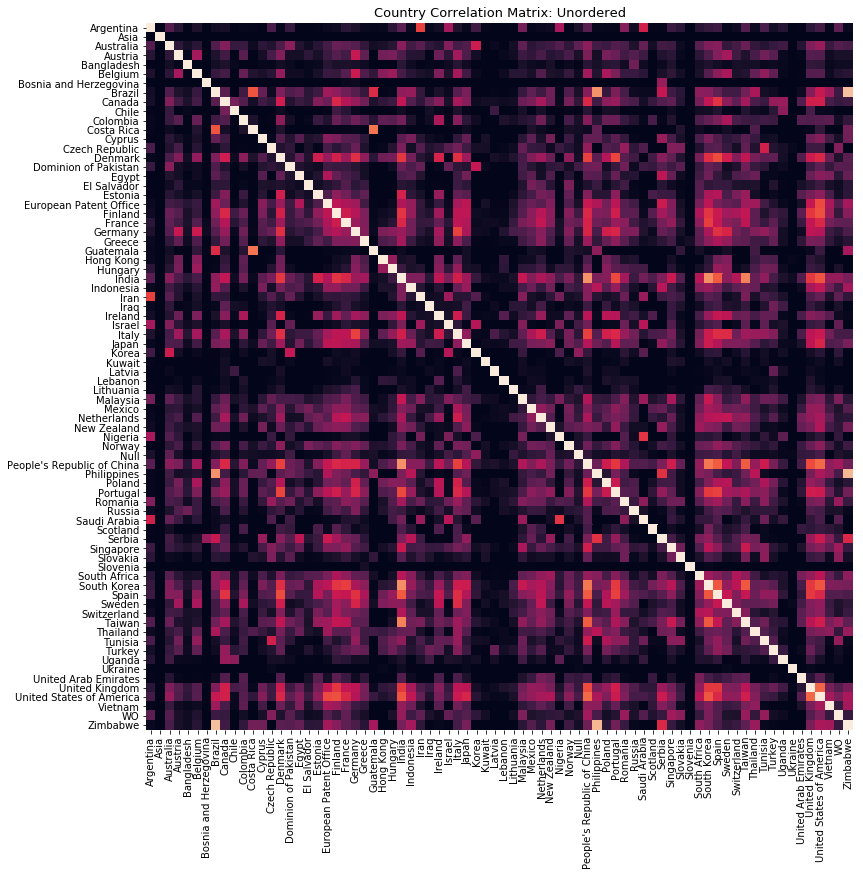

In [28]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(country_correlation, cbar=None, square=True, yticklabels=country_names, xticklabels=country_names)
plt.title('Country Correlation Matrix: Unordered', size=13)
plt.show()

A couple of things worth noting in the first visualization: 
- All of the values of the heatmap are between 0 and 1. 
- A value of 1 indicates the highest level of correlation. For this reason, the diagonal has values equal to 1.(This because it corresponds to the correaltion of a country to itself.) 
- The lighter the color of the correlation, the higher the level of correlation. 
- If a cell in the heatmap is totally dark, this indicates no correlation at all. 

**Light Cell - High Correlation:** This indicates that the capability profile of the two countries concerned is similar. Which can be interpreted as the countries having "similar" research profiles. 

**Dark Cell - Low Correlation:** This indicates that the capability profile of the two countries concerned is different. Which can be interpreted as the countries having divergent research profiles. 

[INTERACTIVE PLOTLY VERSION.](https://plot.ly/~duarteocarmo/24)

#### 2.4.2. Reordered Matrix: Clustermap <a class="anchor" id="two-four-two"></a>

In this part, we will create a clustermap of the heatmap produced in the previous sections. 

To do this, we use the `sns.clustermap` function (see documentation [here](http://seaborn.pydata.org/generated/seaborn.clustermap.html)) that produces two things: 
- A reordered heatmap according to 'similarity'. This method reorders the matrix using Hierarchical agglomerative clustering with single linkage (minimum distance). See more info about this algorithm [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). 
- This clustermap also creates a [dendogram](https://en.wikipedia.org/wiki/Dendrogram) of the linkages that the algorithm produces.


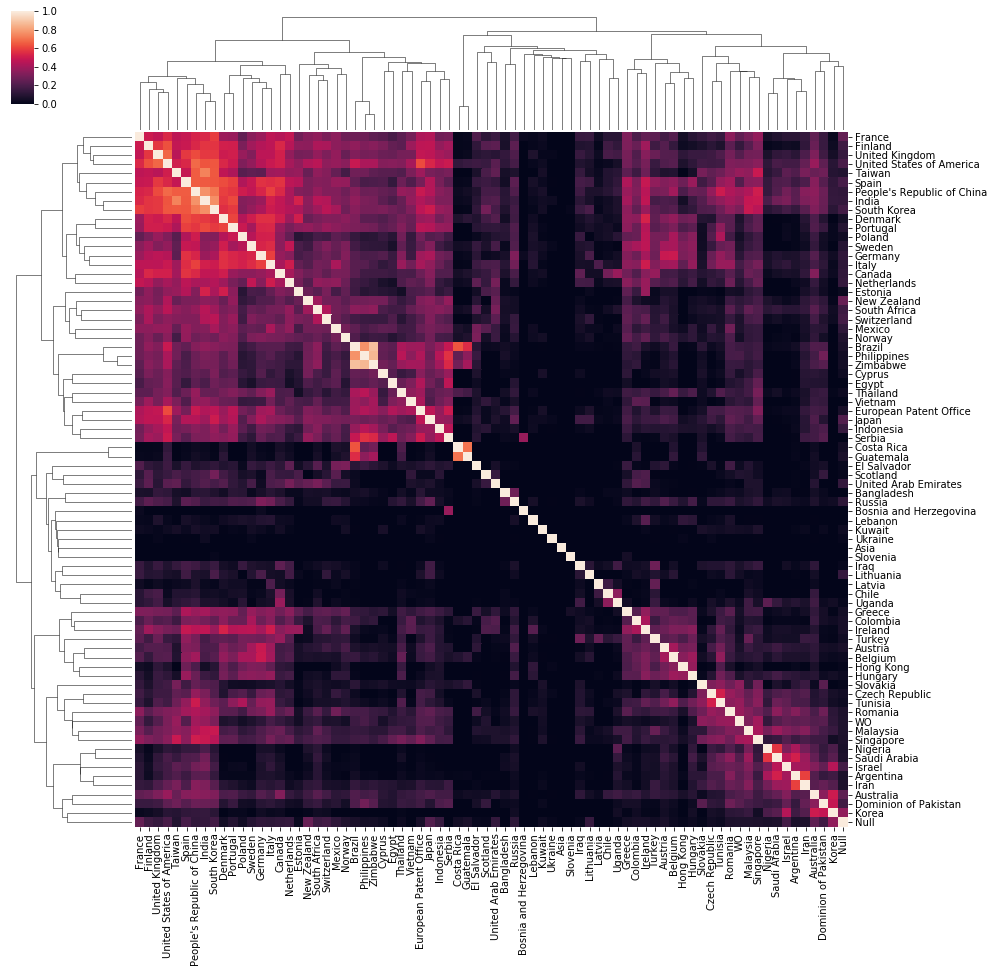

In [29]:
# plot the clustermap
a = sns.clustermap(country_correlation,  figsize=(15, 15), xticklabels = country_names, yticklabels=country_names)
plt.show()

Some interesting observations and hypothesis: 
- **Language matters:** UK and USA, for example, are highly correlated. (68% correlation)
- **Distance matters: ** Costa-Rica and Guatemala have a correlation of 71%.
- **Other Factors might matter: **: Portugal and Denmark for example, have a correlation of 61%. 


*PS: the percentage of correlation is achieved by multiplying the Pearson correlation index by 100.* 

### 2.5. Country profiles <a class="anchor" id="two-five"></a>

Another interesting analysis is understanding how one country relates to other countries itself. This is done by *slicing* the heatmap produced in the previous section. 

By producing a bar plot for every country we can see how it relates to others and possibly find meaningful patterns. 

Let's start by selecting a couple of countries:

In [30]:
countries = ['Denmark', 'United Kingdom']

After selecting countries, we can now plot two different profiles. 

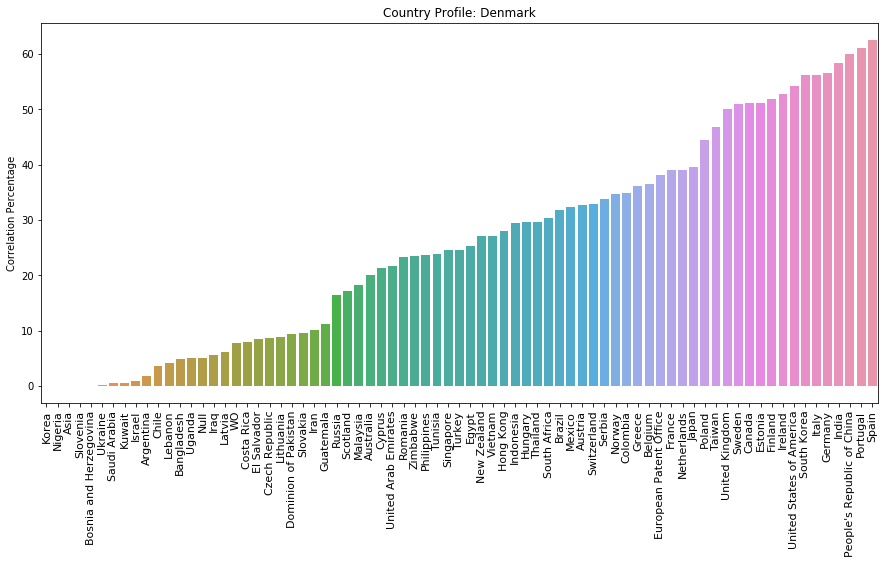

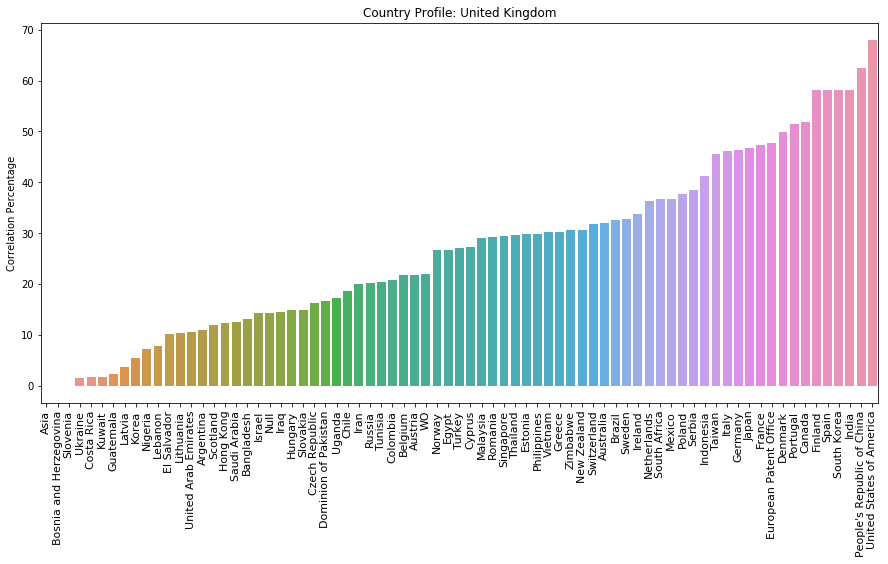

In [31]:
# for each country selected
for country in countries:
    
    # find the matrix slice
    country_index = find_index(country, country_names)
    histogram_data = country_correlation[:, country_index]
    
    # remove the country itself from data and labels
    histogram_data = np.delete(histogram_data, country_index)
    clean_country_names = np.delete(country_names, country_index)
    

    # sort labels and data
    sorted_names = [name for _,name in sorted(zip(histogram_data, clean_country_names))]
    histogram_data.sort()
    
    #plot
    plt.subplots(1,1,figsize=(15,7))
    sns.barplot(np.arange(len(histogram_data)), histogram_data * 100)
    plt.xticks(np.arange(len(histogram_data)), sorted_names, rotation=90, fontsize=11)
    plt.title('Country Profile: {}'.format(country))
    plt.ylabel('Correlation Percentage')
    plt.show()

[INTERACTIVE PLOTLY VERSION](https://plot.ly/~duarteocarmo/26)

Some important information comes from these profiles: 
- Using these profile we can dive deeper into each country to confirm the above hypothesis. 
- Looking at UK's profile, the top three countries with highest correlation with it are: USA, China and India. This can mean that language is a very important factor for correlation but also eceonomic development for example. 
- Looking at Denmark's profile, the 3 most similar countries are: Spain, Portugal and China. This indicates that there is possibly another important factor at play. 

## 3. Contextual Relations (WIP) <a class="anchor" id="three"></a>

We will now study the relationship between the previously found correlations and other characteristics. 

### 3.1. GDP per capita <a class="anchor" id="three-one"></a>


Let us investigate how the GDP per capita is related to the country capabilities. 

The world bank has data available on the GDP per capita for (almost) every country in the world. 

[Source](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)

Let us investigate what countries or elements are not available in the World Bank database: 

In [32]:
data = pd.read_csv('Data/GDP_per_capita.csv', delimiter=';', header=None).as_matrix()
print 'Countries that do not have data:'

for country in country_names:
    if country not in data[:, 0]:
        print country

Countries that do not have data:
Asia
Null


#### 3.1.1. GDP per capita and capabilities <a class="anchor" id="three-one-one"></a>

We delete these entries from the `country_correlation` matrix (our heatmap) and create an `adapted_country_correlation` that is equal, without the entries that do not have GDP data available. 

In [33]:
countries_not_available = ['Asia', 'Null', 'Korea']
index_countries_not_available = [find_index(country, country_names) for country in countries_not_available]

adapted_country_correlation = np.delete(country_correlation, index_countries_not_available, 0)
adapted_country_correlation = np.delete(adapted_country_correlation, index_countries_not_available, 1)

Next, we create a matrix where the GDP's are correlated with each other. Following the structure: 
- Entry(i,j) is the absolute value of the difference between the GDP per capita of country i and j.

In [34]:
# create the matrix
gdps = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])
countries_available = [country for country in country_names if country not in countries_not_available]
countries_available.sort()

# for every entry, calculate the entry
for row in range(len(countries_available)):
    country_1 = countries_available[row]
    country_1_gdp = float(data[find_index(country_1, data[:, 0].tolist()), 1])
    for column in range(len(countries_available)):
        country_2 = countries_available[column]
        country_2_gdp = float(data[find_index(country_2, data[:, 0].tolist()), 1])
    
        gdps[row, column] = abs(country_1_gdp - country_2_gdp)
        
        

gdps_norm = (gdps - np.mean(gdps)) / np.std(gdps)

We can finally plot the GDP per capita difference heatmap. 

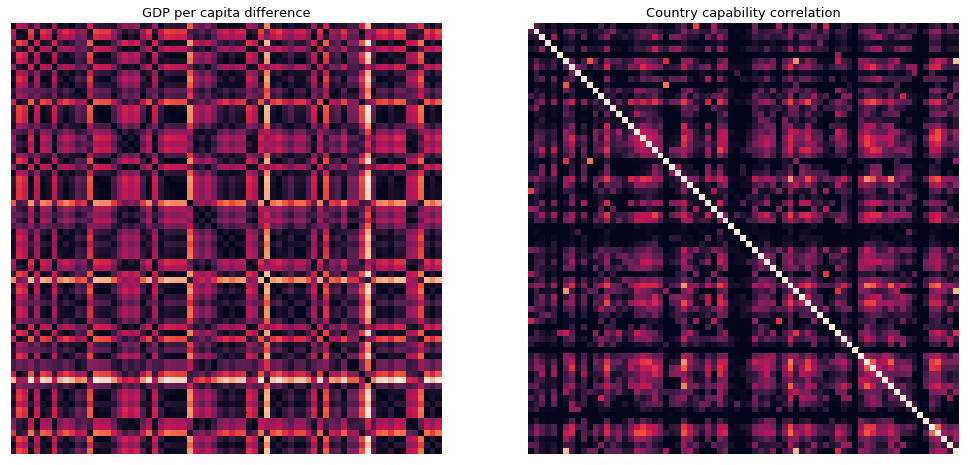

In [35]:
plt.subplots(1,2,figsize=(17,17))

plt.subplot(121)
sns.heatmap(gdps, square=True, cbar=None, yticklabels=False, xticklabels=False)
plt.title('GDP per capita difference', size=13)

plt.subplot(122)
sns.heatmap(adapted_country_correlation, square=True, cbar=None, yticklabels=False, xticklabels=False)
plt.title('Country capability correlation', size=13)
plt.show()

**Left Figure**:  The difference in GDP per capita of all of the countries in the database. The lighter the color in the heatmap, the bigger the difference in the GDP per capita between two countries. 

**Rigth Figure**: The knowledge capability correlation between two countries. The lighter the color, the more correlated their capabilities are. 

Let's study if these two matrixes are correlated in any way. We start by creating a function that flattens the above matrixes, by takingthe upper triangle and discarting anything below it (including the diagonal). 

In [70]:
def custom_flatten(matrix):
    rows = matrix.shape[0]
    cols = matrix.shape[1]
    
    finalList = []
    columnDisplacement = 1 
    for rowNumber in range(rows):
        listToAppend =  matrix[rowNumber, :][columnDisplacement::]
        finalList.extend(listToAppend)
        
        columnDisplacement += 1
    return finalList 

After doing so, we determine two relevant statistics for the correlation study: 

In [37]:
rounding = 4
pearson_ = stats.pearsonr(custom_flatten(gdps), custom_flatten(adapted_country_correlation))[0]
p_value = stats.pearsonr(custom_flatten(gdps), custom_flatten(adapted_country_correlation))[1]
cos_sim = 1 - spatial.distance.cosine(custom_flatten(gdps), custom_flatten(adapted_country_correlation))

print 'Pearson correlation Index: {} (p-value of {})'.format(round(pearson_, rounding), round(p_value, rounding))
print 'Cosine similarity: {}'.format(round(cos_sim, rounding))

Pearson correlation Index: 0.0392 (p-value of 0.0447)
Cosine similarity: 0.5621


The pearson correlation index shows that there is a very small positive correlation between GDP per capita and capability. Moreover, the p-value (< 0.05)comes to show that this assessment is 'statistically relevant'.

#### 3.1.2. Country Profiles and Correlation: Denmark<a class="anchor" id="three-one-two"></a>

**GDP per capita difference**

Let us first see how every country is different from Denmark in terms of GDP per capita. To do this, we plot all of the countries by difference in GDP per capita, and then order this plot. 

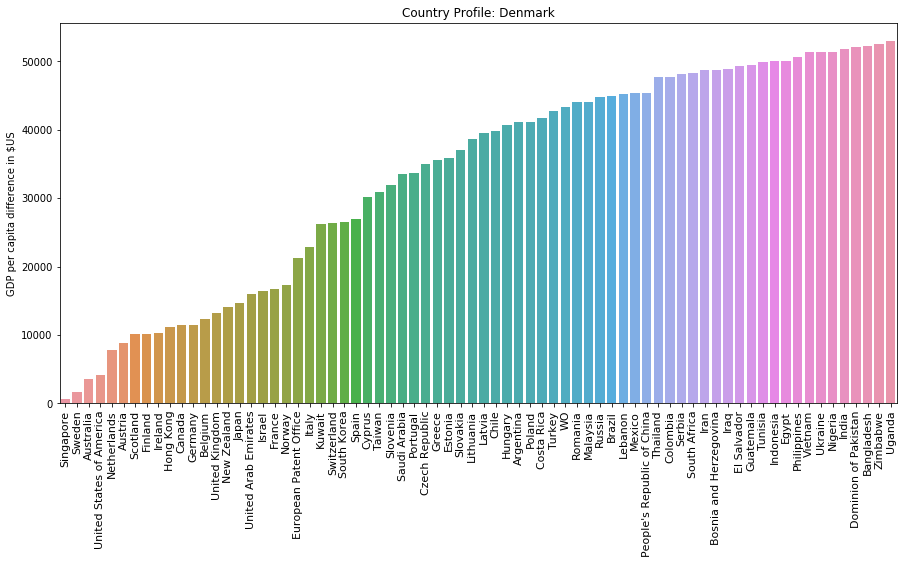

In [38]:
country = 'Denmark'

# find the matrix slice
country_index = find_index(country, countries_available)
raw_histogram_data_gdps = gdps[:, country_index]
raw_histogram_data_corr = adapted_country_correlation[:, country_index] 

# remove the country itself from data and labels
clean_histogram_data_gpds = np.delete(raw_histogram_data_gdps, country_index)
clean_histogram_data_corr = np.delete(raw_histogram_data_corr, country_index)
clean_country_names = np.delete(countries_available, country_index)
    
# sort labels and data
bar_names = [x for _,x in sorted(zip(clean_histogram_data_gpds, clean_country_names))]
bars = sorted(clean_histogram_data_gpds)

#plot
plt.subplots(1,1,figsize=(15,7))
sns.barplot(np.arange(len(bars)), bars)
plt.xticks(np.arange(len(bars)), bar_names, rotation=90, fontsize=11)
plt.title('Country Profile: {}'.format(country))
plt.ylabel('GDP per capita difference in $US')
plt.show()

As expected, the countries that have a closer GDP per capita are countries that are close geographically, but also countries that are close from an economic prespective. 

**GDP per capita and capability correlation**

After visualizing the difference in GDP per capita, we wish to understand if this difference is related to capability correlations in any way.

To do this, we produce a scatter plot where each data point corresponds to a particular country, and we print the correlation index.  

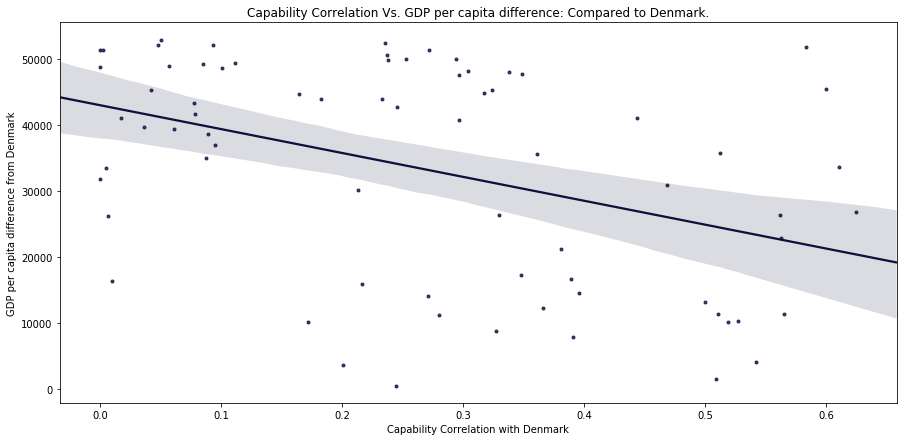

The pearson correlation between these two variables is -0.417800766914 with a p-value of 0.000260573700838.


In [246]:
# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(clean_histogram_data_corr, clean_histogram_data_gpds, marker=".", color = '#0e103d')
plt.xlabel('Capability Correlation with {}'.format(country))
plt.ylabel('GDP per capita difference from {}'.format(country))
plt.title('Capability Correlation Vs. GDP per capita difference: Compared to {}.'.format(country))
plt.show()


correlation_score = stats.pearsonr(clean_histogram_data_corr, clean_histogram_data_gpds)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])

There seems to be a significant negative correlation between these, which is expressed in the following way: 
- Countries with high GDP per capita difference have low capability correlations
- Countries with low GDP per capita difference have high capability correlations

Let us visualize these two clusters. 

**Density Plot**

We produce a seaborn density plot.

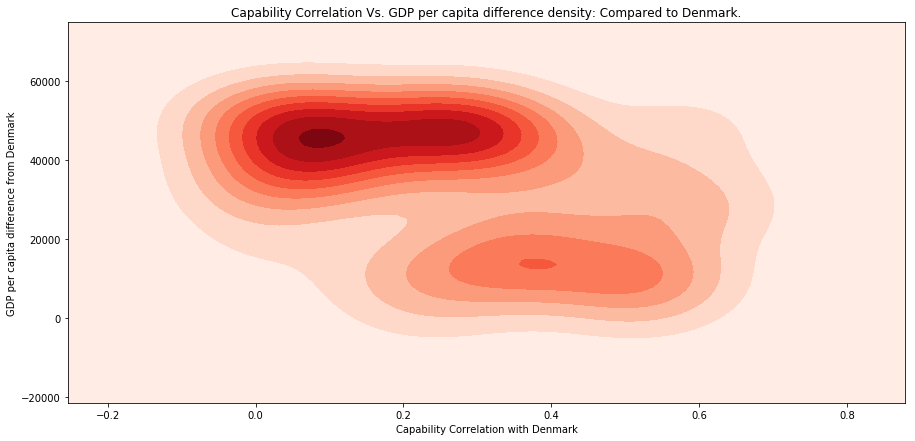

In [40]:
# density plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.kdeplot(clean_histogram_data_corr, clean_histogram_data_gpds, cmap="Reds", shade=True)
plt.xlabel('Capability Correlation with {}'.format(country))
plt.ylabel('GDP per capita difference from {}'.format(country))
plt.title('Capability Correlation Vs. GDP per capita difference density: Compared to {}.'.format(country))
plt.show()

The above mentioned clusters are clear in this density plot.

#### 3.1.3. Country Profiles and Correlation: Other Countries <a class="anchor" id="three-one-three"></a>

**Global Correlations- Scatter Plot**

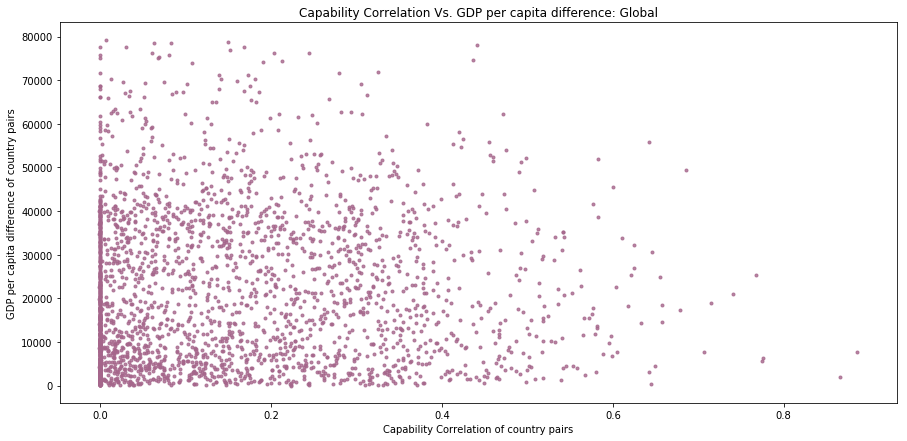

The pearson correlation between these two variables is 0.0391584053214 with a p-value of 0.0447249475938.


In [242]:
# create global lists for gdps difference and 
globalGDP = np.asarray(custom_flatten(gdps))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalCapabilityCorrelation, globalGDP,fit_reg=False, marker=".", color = '#a5668b')
plt.xlabel('Capability Correlation of country pairs')
plt.ylabel('GDP per capita difference of country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference: Global')
plt.show()

# get correlation score
correlation_score = stats.pearsonr(globalCapabilityCorrelation, globalGDP)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])

**Global Correlations - Scatter Plot Version 2**

As can be noticed above, there are a lot of country pairs that have a 0 capability correlation. This can happen for severall reasons: 
- One of the countries does not have a significant number of assets. 
- Both countries have a very low number of assets. 

To understant the reach of this trait, the same plot is reproduced whyle ignoring the country pairs with 0 capability correlation. 

A total of 634 entries were eliminated from 2628.


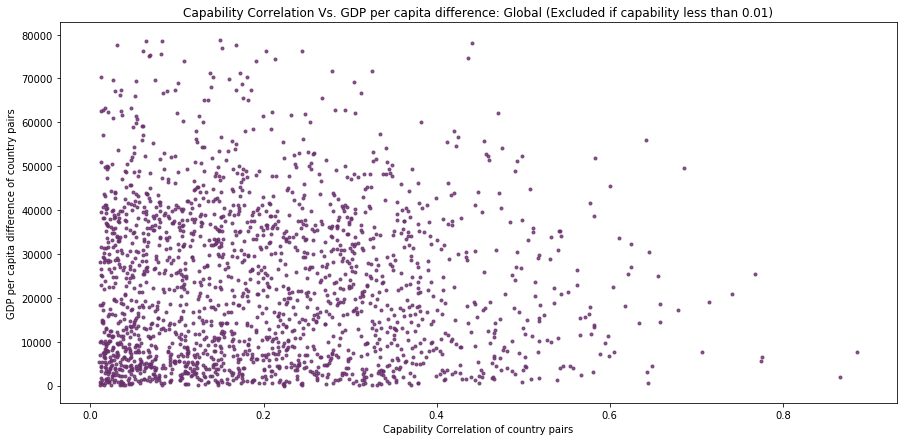

The pearson correlation between these two variables is -0.0346418268588 with a p-value of 0.122008447046.


In [243]:
# create global lists for gdps difference and 
globalGDP = np.asarray(custom_flatten(gdps))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# eliminate pairs with no correlation 
capabilityThreshold = 0.01
globalGDP_notNull = globalGDP[globalCapabilityCorrelation > capabilityThreshold]
globalCapabilityCorrelation_notNull = globalCapabilityCorrelation[globalCapabilityCorrelation  > capabilityThreshold]

print 'A total of {} entries were eliminated from {}.'.format(len(globalCapabilityCorrelation) - len(globalCapabilityCorrelation_notNull), len(globalCapabilityCorrelation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalCapabilityCorrelation_notNull, globalGDP_notNull,fit_reg=False, marker=".", color = '#69306d')
plt.xlabel('Capability Correlation of country pairs')
plt.ylabel('GDP per capita difference of country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference: Global (Excluded if capability less than {})'.format(capabilityThreshold))
plt.show()

# get correlation score
correlation_score = stats.pearsonr(globalCapabilityCorrelation_notNull, globalGDP_notNull)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])

Let us investigate some outliers:

In [107]:
gdpPerCapitaLowerLimit = 45000
capabilityCorrelationLowerLimit = 0.5

print 'Outliers'
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if np.triu(gdps, 1)[i,j]>gdpPerCapitaLowerLimit and np.triu(adapted_country_correlation, 1)[i,j]> capabilityCorrelationLowerLimit:
            print countries_available[i],'-', countries_available[j]
                

Outliers
Denmark - India
Denmark - People's Republic of China
India - United States of America
People's Republic of China - United States of America


**Global Correlations- Density Plot**

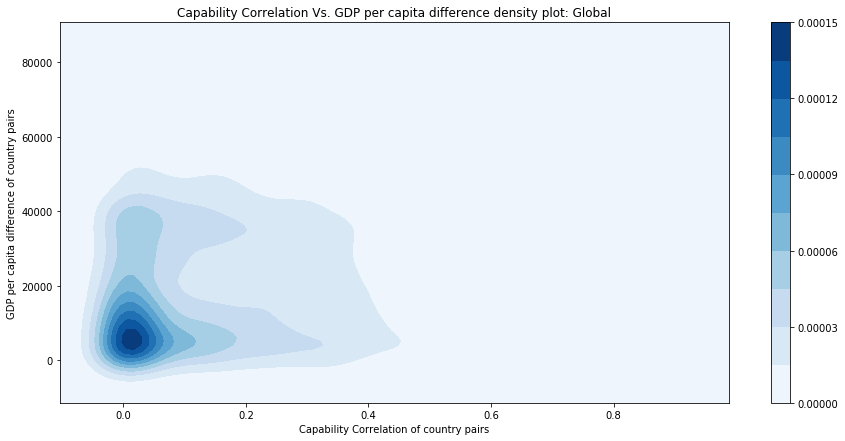

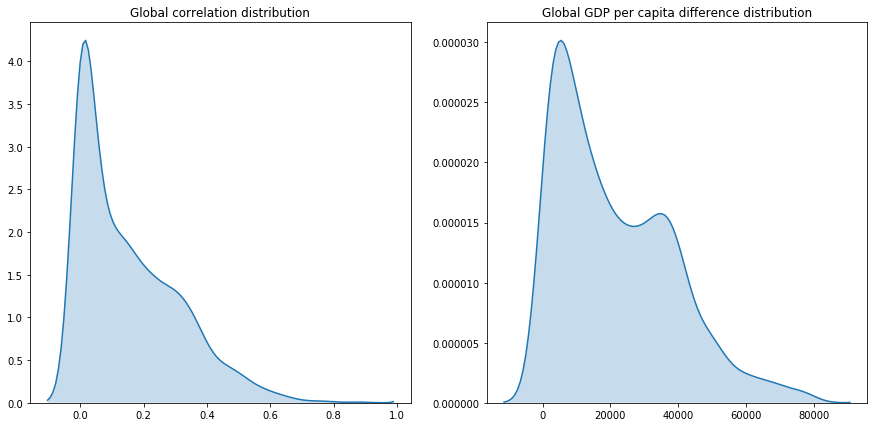

In [108]:
# density plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.kdeplot(globalCapabilityCorrelation, globalGDP, cmap="Blues", shade=True, cbar = True)
plt.xlabel('Capability Correlation of country pairs')
plt.ylabel('GDP per capita difference of country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference density plot: Global')
plt.show()



plt.subplots(1,2,figsize=(15,7))

plt.subplot(121)
sns.kdeplot(globalCapabilityCorrelation,  shade=True)
plt.title('Global correlation distribution')


plt.subplot(122)
sns.kdeplot(globalGDP,  shade=True)
plt.title('Global GDP per capita difference distribution')
plt.show()

**GDP p. capita - Capability Correlation for every country**

To better understand this, we now study this correlation for every country. 

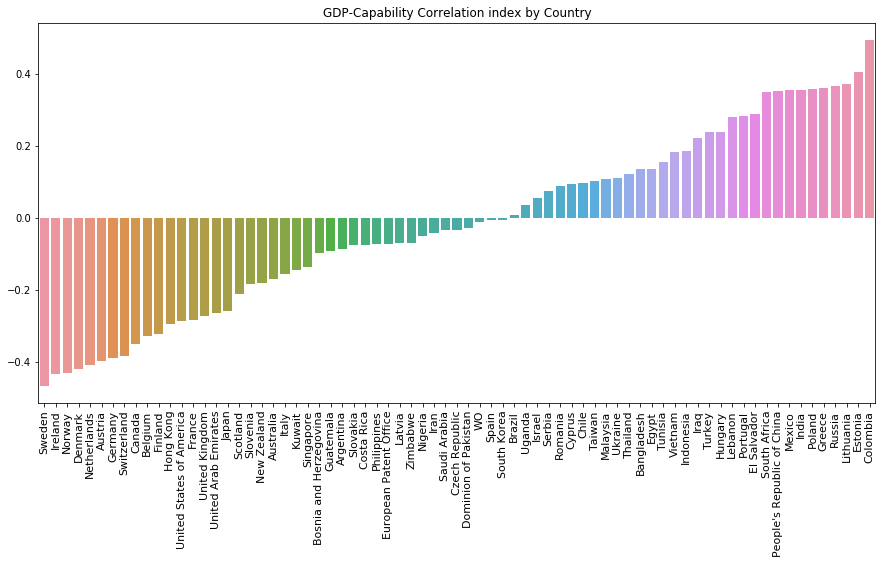

In [109]:
pearson_dict = {}
# for each country selected
for ind_country in countries_available:

    # find the matrix slice
    country_index = find_index(ind_country, countries_available)
    histogram_data_gdps = gdps[:, country_index]
    histogram_data_corr = adapted_country_correlation[:, country_index] 
    
    # remove the country itself from data and labels
    histogram_data_gpds = np.delete(histogram_data_gdps, country_index)
    histogram_data_corr = np.delete(histogram_data_corr, country_index)
    clean_country_names = np.delete(countries_available, country_index)
    
    # add entry to a dictionnary that dictionnary[country] = pearson correlation value
    pearson_dict[ind_country] = stats.pearsonr(histogram_data_corr, histogram_data_gpds)[0]
    


sorted_dict = sorted(pearson_dict.items(), key=operator.itemgetter(1))
b_countries = [e[0] for e in sorted_dict]
correlations = [e[1] for e in sorted_dict]


plt.subplots(1,1,figsize=(15,7))
sns.barplot(np.arange(len(correlations)), correlations)
plt.xticks(np.arange(len(correlations)), b_countries, rotation=90, fontsize=11)
plt.title('GDP-Capability Correlation index by Country')
plt.show()

### 3.2. Collaborations <a class="anchor" id="three-two"></a>

#### 3.2.1. Collaboration Matrix <a class="anchor" id="three-two-one"></a>

The goal of this part of the analysis is to understand if the number of collaborations between countries plays a part in their correlation.

To understand this let us create a matrix of collaborations.

We start by creating the right query and building the matrix. 

In [110]:
# create Query 
colabQuery = """ MATCH (a:Asset)-[:LOCATED_IN]->(ac:Country)
            MATCH (b:Asset)-[:LOCATED_IN]->(bc:Country)
            WHERE a.id = b.id AND ac.name <> bc.name
            RETURN ac.name, bc.name ,count(a.id)
            ORDER BY count(a.id) DESC"""

# extract matrix from query
colabData = DataFrame(connection_to_graph.data(colabQuery)).as_matrix()

# create empty collaboration matrix 
colabMatrix = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])

for row in range(len(countries_available)):
    firstCountry = countries_available[row]
    for col in range(len(countries_available)):
        secondCountry = countries_available[col]
        
        # if first and second country match, put value in matrix and break loop. 
        for data_row in colabData:
            if firstCountry == data_row[0] and secondCountry == data_row[1]:
                found = 1
                colabMatrix[row,col] = data_row[2]
                break

We start by plotting the heatmap of our collaboration matrix. 

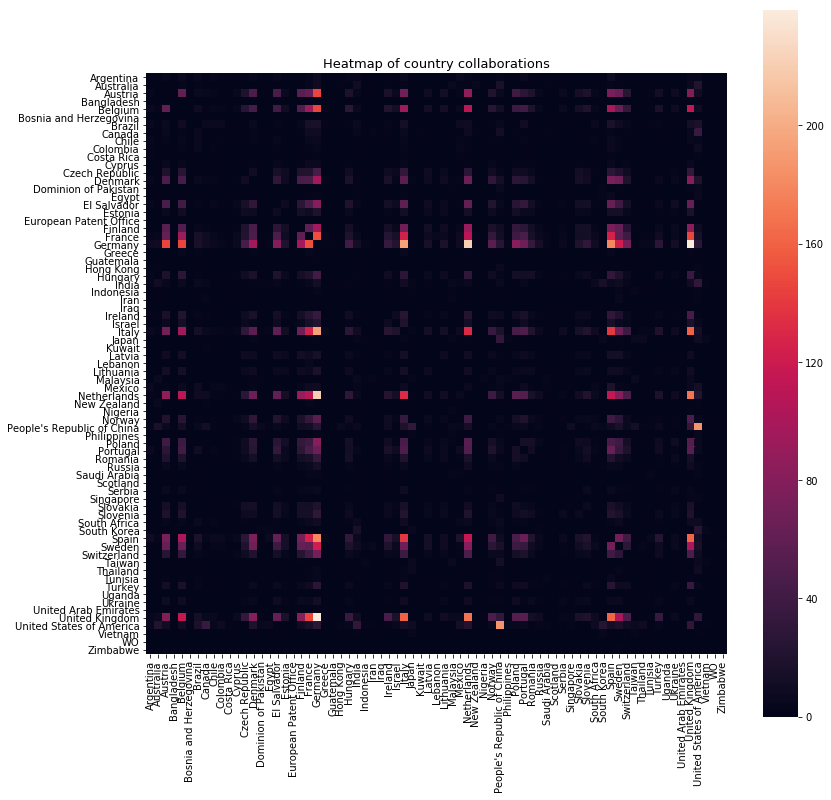

In [111]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(colabMatrix, square=True, yticklabels=countries_available, xticklabels=countries_available)
plt.title('Heatmap of country collaborations', size=13)
plt.show()

Let us create a verification tool to understand if everything is working properly. 

In [112]:
firstCountry= 'Germany'
secondCountry= 'United Kingdom'


firstIndex = countries_available.index(firstCountry)
secondIndex = countries_available.index(secondCountry)

print '{} and {} have {} assets in common. Value: {}; Symmetrical Value: {}.'.format(firstCountry, secondCountry, colabMatrix[firstIndex, secondIndex], colabMatrix[firstIndex, secondIndex], colabMatrix[secondIndex, firstIndex])

Germany and United Kingdom have 239.0 assets in common. Value: 239.0; Symmetrical Value: 239.0.


This corresponds to the neo4j value found in the database.

#### 3.2.2. Collaborations and Capabilities <a class="anchor" id="three-two-two"></a>

We now seek to understand the relationship between collaborations and capacbility correlation in our data. 

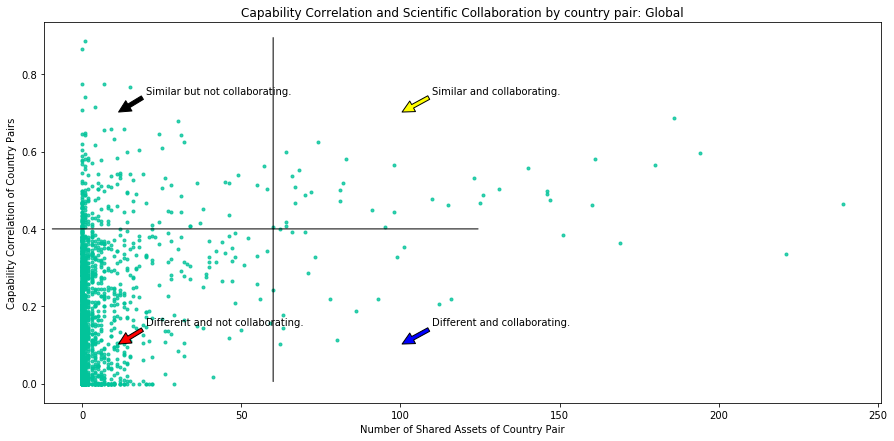

The pearson correlation between these two variables is 0.341840469495 with a p-value of 6.27022480157e-73.


In [244]:
# create global lists for gdps difference and 
globalCollaborations = np.asarray(custom_flatten(colabMatrix))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalCollaborations, globalCapabilityCorrelation,fit_reg=False, marker=".", color = '#02c39a')
plt.ylabel('Capability Correlation of Country Pairs')
plt.xlabel('Number of Shared Assets of Country Pair')
plt.title('Capability Correlation and Scientific Collaboration by country pair: Global')

# annotations
plt.annotate('Similar but not collaborating.', xy=(11, 0.7), xytext=(20, 0.75),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Different and not collaborating.', xy=(11, 0.1), xytext=(20, 0.15),arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Similar and collaborating.', xy=(100, 0.7), xytext=(110, 0.75),arrowprops=dict(facecolor='yellow', shrink=0.05))
plt.annotate('Different and collaborating.', xy=(100, 0.1), xytext=(110, 0.15),arrowprops=dict(facecolor='blue', shrink=0.05))
plt.annotate("",xy=(60, 0.0), xycoords='data',xytext=(60, 0.9), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)
plt.annotate("",xy=(-10, 0.4), xycoords='data',xytext=(125, 0.4), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)


plt.show()

# get correlation score
correlation_score = stats.pearsonr(globalCapabilityCorrelation, globalCollaborations)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])

In [114]:
print 'Different and not Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]<60 and adapted_country_correlation[i,j]< 0.4:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Different and not Collaborating:
Argentina - Australia
Australia - Argentina
Austria - Argentina
Bangladesh - Argentina


In [115]:
print 'Different and Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]>60 and adapted_country_correlation[i,j]< 0.4:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Different and Collaborating:
Austria - France
Belgium - France
Denmark - Netherlands
El Salvador - Germany


In [116]:
print 'Similar but not Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]<60 and adapted_country_correlation[i,j]> 0.4 and adapted_country_correlation[i,j]< 0.8:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Similar but not Collaborating:
Argentina - Iran
Belgium - People's Republic of China
Brazil - Costa Rica
Canada - Denmark


In [117]:
print 'Similar and Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]>75 and adapted_country_correlation[i,j]> 0.4 and adapted_country_correlation[i,j]< 0.8:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Similar and Collaborating:
Austria - Germany
Belgium - Germany
Denmark - Germany
Finland - Germany


#### 3.2.3. Normalized Collaborations and Capabilities <a class="anchor" id="three-two-three"></a>

In order to more deeply understand the relationship between collaborations and capabilities, we will normalized the collaborations part of the procedure. To do this, we must specify: 
- Old collaboration definition: Country `i` and country `j` have `z` assets that have both their name as location. 
- New **normalized** collaboration definition: 
`normalized_collaboration`= (` number of shared assets between country i and j`)/(` number of total possible collaborations between i and j`)

Let us create a function that given a country returns its number of assets. 

In [160]:
def get_asset_number(country):
    numberQuery = """   MATCH (a:Asset)-[:LOCATED_IN]->(ac:Country)
                        WHERE ac.name = "{}"
                        RETURN count(a)""".format(country)
    return DataFrame(connection_to_graph.data(numberQuery)).as_matrix()[0][0]

And we create the `normalizedColabMatrix`:

In [162]:
normalizedColabMatrix = np.zeros(adapted_country_correlation.shape)

for rowNumber in range(len(countries_available)):
    first_country = countries_available[rowNumber]
    first_country_assets = get_asset_number(first_country)
    for colNumber in range(len(countries_available)):
        second_country = countries_available[colNumber]
        second_country_assets = get_asset_number(second_country)
        
        normalizedColabMatrix[rowNumber, colNumber] = colabMatrix[rowNumber, colNumber] / min(first_country_assets, second_country_assets)

Let us check if everything is working properly: 

In [167]:
country_1 = 'Denmark'
country_2 = 'Portugal'

country_1_index = countries_available.index(country_1)
country_2_index = countries_available.index(country_2)

print 'Number of assets {}: '.format(country_1), get_asset_number(country_1)
print 'Number of assets {}: '.format(country_2), get_asset_number(country_2)
print 'Number of shared assets: ', colabMatrix[country_1_index, country_2_index]
print 'Number of normalized shared assets: ', normalizedColabMatrix[country_1_index, country_2_index]

Number of assets Denmark:  351
Number of assets Portugal:  180
Number of shared assets:  25.0
Number of normalized shared assets:  0.1388888888888889


Since the maximum number of shared assets in this case is 180, the normalized shared assets as described above should be 25/180, which is indeed equal to 0.14.

We can now reproduce a scatter plot where:
- the `x` axis corresponds to the number of **normalized** shared assets between a country pair
- the `y` axis corresponds to the capability correlation for that same country pair. 

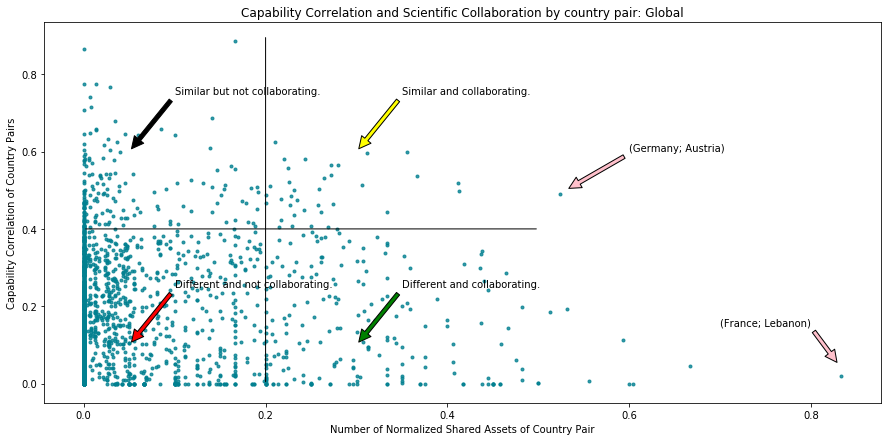

The pearson correlation between these two variables is 0.129891665396 with a p-value of 2.32610303067e-11.
Capability Correlation Mean:  0.15265990327971085
Normalized Collaboration Mean:  0.04922511209177974


In [239]:
# create global lists for gdps difference and 
globalNormalizedCollaborations = np.asarray(custom_flatten(normalizedColabMatrix))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalNormalizedCollaborations, globalCapabilityCorrelation,fit_reg=False, marker=".", color = '#028090')
plt.ylabel('Capability Correlation of Country Pairs')
plt.xlabel('Number of Normalized Shared Assets of Country Pair')
plt.title('Capability Correlation and Scientific Collaboration by country pair: Global')

# annotations
plt.annotate('Similar but not collaborating.', xy=(0.05, 0.6), xytext=(0.1, 0.75),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Different and not collaborating.', xy=(0.05, 0.1), xytext=(0.1, 0.25),arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Similar and collaborating.', xy=(0.3, 0.6), xytext=(0.35, 0.75),arrowprops=dict(facecolor='yellow', shrink=0.05))
plt.annotate('Different and collaborating.', xy=(0.3, 0.1), xytext=(0.35, 0.25),arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate("",xy=(0.2, 0.0), xycoords='data',xytext=(0.2, 0.9), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)
plt.annotate("",xy=(0, 0.4), xycoords='data',xytext=(0.5, 0.4), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)
plt.annotate('(France; Lebanon)', xy=(0.83, 0.05), xytext=(0.7, 0.15),arrowprops=dict(facecolor='pink', shrink=0.05))
plt.annotate('(Germany; Austria)', xy=(0.53, 0.5), xytext=(0.6, 0.6),arrowprops=dict(facecolor='pink', shrink=0.05))


plt.show()

# get correlation score
correlation_score = stats.pearsonr(globalCapabilityCorrelation, globalNormalizedCollaborations)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])
print 'Capability Correlation Mean: ', np.mean(globalCapabilityCorrelation)
print 'Normalized Collaboration Mean: ', np.mean(globalNormalizedCollaborations)

Let us analyze some of the datapoints:

In [240]:
print 'Different and Collaborating (Limited):'
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if np.triu(normalizedColabMatrix, 1)[i,j]>0.5 and np.triu(adapted_country_correlation, 1)[i,j]<0.4:
            print countries_available[i],'-', countries_available[j]   

Different and Collaborating (Limited):
Canada - Kuwait
El Salvador - Germany
Estonia - Germany
France - Lebanon
Germany - Latvia
Germany - Lithuania
Germany - Slovenia
Germany - Ukraine


In [241]:
print 'Similar and Collaborating (Limited):'
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if np.triu(normalizedColabMatrix, 1)[i,j]>0.3 and np.triu(adapted_country_correlation, 1)[i,j]>0.4:
            print countries_available[i],'-', countries_available[j]

Similar and Collaborating (Limited):
Austria - Germany
Belgium - Germany
Estonia - Spain
Germany - Italy
Germany - Poland
Germany - Portugal
Portugal - Spain
Portugal - United Kingdom


## 4. The case of Denmark <a class="anchor" id="four"></a>

### 4.1. Visualizing Differences <a class="anchor" id="four-one"></a>

We will start by producing a macro visualization of the capability matrix of Denmark and the capability matrix of Sweden. For now, we will not focus on the exact capabilities taht differ, but just compare them side by side, without normalizing. 

We use the functions previsouly produced. 

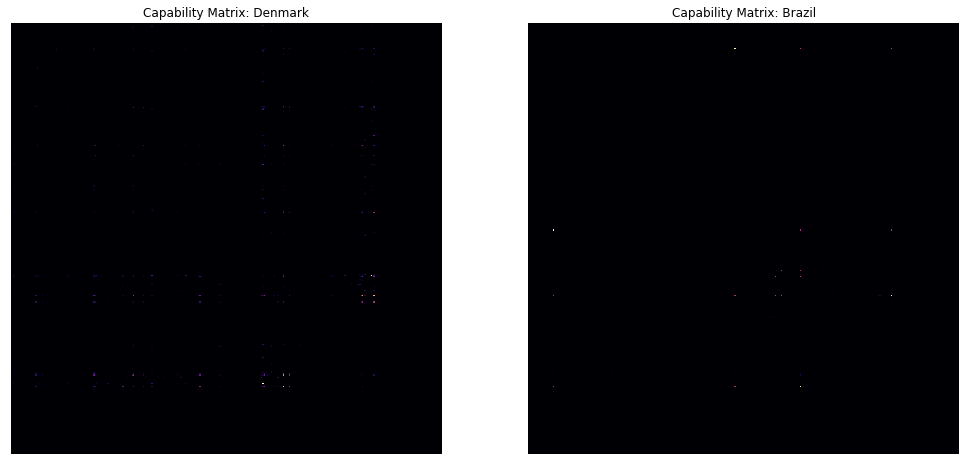

In [132]:
# call functions
denmark = 'Denmark'
compare_with = 'Brazil'
colors = 'magma'
dk_matrix = get_country_matrix(denmark, normalization=False)
scnd_matrix = get_country_matrix(compare_with, normalization=False)

# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(dk_matrix, cmap=colors,  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(denmark))

# second heatmap
plt.subplot(122)
sns.heatmap(scnd_matrix, cmap=colors, cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(compare_with))
plt.show()

Next, let us create the map of differences, where: 

differences[i, j] = abs(denmark[i,j] - other_country[i, j]) for every i and j

In [133]:
cap_diff = np.absolute(dk_matrix - scnd_matrix)

And plot the heatmap

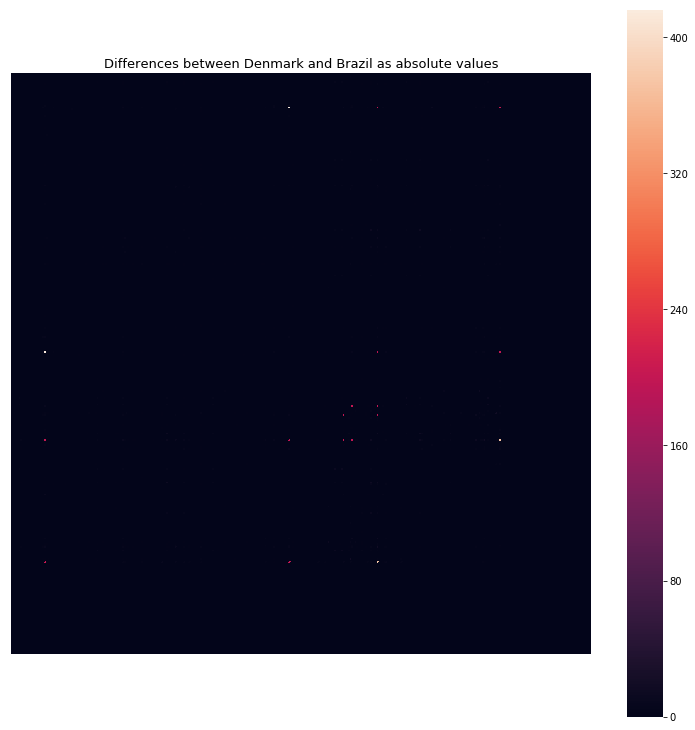

In [134]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(cap_diff, square=True, yticklabels=False, xticklabels=False)
plt.title('Differences between Denmark and {} as absolute values'.format(compare_with), size=13)
plt.show()

### 4.2. Understanding Differences <a class="anchor" id="four-two"></a>

Let us analyze the capability pairs where denmark and the other country have the most documents. 

We create a function that given a matrix, returns its top hits. 

In [135]:

def get_top_hits(countryMatrix, name):
    """
    The function prints the top occurences if fed a matrix of occurences, it also prints other types of valuable info.
    WARNING: Percentages are shown as 0 to 1. 
    """
        
    # list where all the values and indexes of matrix are stored
    top = 10
    values = []
    indexes = []
    no_duplicates = np.triu(countryMatrix, 1)
    total_documents = np.sum(no_duplicates)
    
    
    # loop through the matrix
    for row_n in range(dk_matrix.shape[0]):
        for col_n in range(dk_matrix.shape[1]):
            values.append(no_duplicates[row_n, col_n])
            indexes.append((row_n, col_n))
    
    
    # order the indexes and get the top
    Z = [indexes for _,indexes in sorted(zip(values,indexes))]
    extremes = Z[-top :]
    
    
    # create dataframe
    term_Dataframe = pd.DataFrame(
        {'First Term': [matrix_axis_names[e[0]] for e in extremes],
         'Second Term': [matrix_axis_names[e[1]] for e in extremes],
         'Number of Documents': [int(no_duplicates[e[0], e[1]]) for e in extremes], 
         'Percentage' : [no_duplicates[e[0], e[1]] / float(total_documents) for e in extremes], 
        })
    
    # prepare dataframe
    term_Dataframe = term_Dataframe[['First Term', 'Second Term','Number of Documents', 'Percentage']]
    term_Dataframe = term_Dataframe.sort_values('Number of Documents', ascending=False)
    
    
    # print everything
    print 'The top hits for the {} matrix: '.format(name)
    display(HTML(term_Dataframe.to_html(index=False)))
    
    
    print 'The total number of documents is {}.'.format(int(total_documents))
    print 'Note: Percentages are as 0-1 in this table. '

And we run the function on both our countries. 

Denmark:

In [136]:
get_top_hits(dk_matrix, denmark)

The top hits for the Denmark matrix: 


First Term,Second Term,Number of Documents,Percentage
biogas,anaerobic digestion,31,0.038994
ethanol,fermentation,26,0.032704
ethanol,hydrolysis,23,0.028931
straw,ethanol,14,0.017610
bioethanol,fermentation,14,0.017610
yeast,fermentation,12,0.015094
cellulosic ethanol,ethanol,12,0.015094
ethanol,enzymatic hydrolysis,12,0.015094
bioethanol,hydrolysis,12,0.015094
cellulosic ethanol,fermentation,11,0.013836


The total number of documents is 795.
Note: Percentages are as 0-1 in this table. 


We notice that outputs play a major role in the capability matrix. Biogas, ethanol and fermentation are some of the terms that appear the most. 

And the other country. 

In [137]:
get_top_hits(scnd_matrix, compare_with)

The top hits for the Brazil matrix: 


First Term,Second Term,Number of Documents,Percentage
sugar,sugarcane,416,0.103251
ethanol,fermentation,401,0.099528
sugar,fermentation,210,0.052122
cellulosic ethanol,ethanol,208,0.051626
sugar,ethanol,207,0.051378
advanced biofuel,cellulosic ethanol,200,0.049640
advanced biofuel,ethanol,200,0.049640
sugarcane,fermentation,198,0.049144
sugarcane,ethanol,195,0.048399
ethanol,hydrolysis,42,0.010424


The total number of documents is 4029.
Note: Percentages are as 0-1 in this table. 


We will now understand where the biggest differences are. 

In [138]:
# list where all the values and indexes of matrix are stored
dk_perc = dk_matrix / np.sum(np.triu(dk_matrix, 1)) * 100 # half only  
other_perc = scnd_matrix / np.sum(np.triu(scnd_matrix, 1)) * 100
differences = dk_perc - other_perc
values = []
indexes = []
no_duplicates = np.triu(differences, 1)

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

# print the table 
Z = [indexes for _,indexes in sorted(zip(values,indexes))]
#extremes = Z[0:10] + Z[-10:]
extremes = Z[0:20]


term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in extremes],
     'Second Term': [matrix_axis_names[e[1]] for e in extremes],
     'Denmark Percentage': [dk_perc[e[0], e[1]] for e in extremes], 
     '{} Percentage'.format(compare_with): [other_perc[e[0], e[1]] for e in extremes], 
     'Difference in %': [no_duplicates[e[0], e[1]] for e in extremes]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', 'Denmark Percentage', '{} Percentage'.format(compare_with), 'Difference in %']]


display(HTML(term_Dataframe.to_html(index=False)))
print 'Percentages are as 0-100 in this table for easy viz.'

First Term,Second Term,Denmark Percentage,Brazil Percentage,Difference in %
sugar,sugarcane,0.000000,10.325143,-10.325143
ethanol,fermentation,3.270440,9.952842,-6.682402
advanced biofuel,cellulosic ethanol,0.000000,4.964011,-4.964011
advanced biofuel,ethanol,0.000000,4.964011,-4.964011
sugarcane,fermentation,0.000000,4.914371,-4.914371
sugarcane,ethanol,0.000000,4.839911,-4.839911
sugar,fermentation,0.628931,5.212211,-4.583281
sugar,ethanol,0.628931,5.137751,-4.508820
cellulosic ethanol,ethanol,1.509434,5.162571,-3.653137
biodiesel,transesterification,0.000000,0.397121,-0.397121


Percentages are as 0-100 in this table for easy viz.


Here, some patterns start emerging, the top half of the list shows where the country we are comparing to has more capabilities when compared to Denmark. The bottom half of the table, shows where Denmark has more focus. 